# Generisanje panorame primenom projektivnih transformacija
**Napomena** : Suštinski deo je tek od podnaslova "**Slike koje želimo da spojimo**", ostalo su sve iskopirane metode za algoritme DLT, modifikovani DLT i samo formiranje GUI - ja za odabir tačaka.

In [15]:
# neophodni importi
import numpy as np
import matplotlib.pyplot as plt
import math

from tkinter import *
from PIL import Image, ImageTk
from copy import deepcopy

## DLT algoritam

In [25]:
def M(point, point_picture):
    l1 = [0,0,0,
          -point_picture[2] * point[0], 
          -point_picture[2] * point[1],
          -point_picture[2] * point[2],
          point_picture[1] * point[0],
          point_picture[1] * point[1],
          point_picture[1] * point[2]]
    
    l2 = [point_picture[2] * point[0], 
          point_picture[2] * point[1],
          point_picture[2] * point[2],0,0,0,
         -point_picture[0] * point[0], 
          -point_picture[0] * point[1],
          -point_picture[0] * point[2]]
    return (l1,l2)

In [26]:
def A_matrix(points_originals, points_pictures):
    A = []
    n = len(points_originals)
    for i in range(0,n):
        hs = M(point=points_originals[i], point_picture=points_pictures[i])
        A.append(hs[0])
        A.append(hs[1])
    return A

In [27]:
def DLT(points_originals, points_pictures):
    A = A_matrix(points_originals, points_pictures)
    decomposition = np.linalg.svd(np.array(A))
    
    transformation_ = np.array(decomposition[2][-1]).reshape(3,3)

    return transformation_

In [30]:
points_originals = [[354,188], [365, 314], [469, 254], [452, 113]]
points_pictures  = [[369,179], [387, 337], [533, 334], [521, 151]]

In [31]:
def from_pixels(point):
    p = [float(point[0]), float(point[1]), 1.0]
    return p

## Modifikovani DLT algoritam

In [33]:
def center_of_points(points):
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]
    
    return (np.average(xs), np.average(ys))

In [34]:
def scaling_to_sqrt_2(points): 
    sigma = 0
    for (x,y) in points:
        sigma += math.sqrt(x**2 + y**2)
    sigma /= (len(points))
    k = math.sqrt(2) / sigma
    return np.array([[k,0,0], [0,k,0],[0,0,1]]).reshape(3,3)

In [35]:
def get_affine(points):
    return [(x[0]/x[2], x[1]/x[2]) for x in points]

In [36]:
def to_homogenous(points):
    return [(x[0], x[1], 1) for x in points]

In [37]:
def normalization(points):
    a_points = get_affine(points)
    t = center_of_points(a_points)
    
    # matrix of translation
    T = np.array([[1,0,-t[0]],
                  [0,1,-t[1]],
                  [0,0,1]  ])
    S = scaling_to_sqrt_2(a_points)
    return np.dot(S, T)

In [38]:
def normalize_points(points):
    points_arg = []
    N = normalization(points)
    
    for point in points:
        p = np.dot(N,np.array(point).reshape(3,1)).reshape(1,3)[0]
        points_arg.append(p)
    
    return points_arg

In [39]:
def modified_DLT(points_originals, points_pictures):
    N_o = normalization(points_originals)
    N_p = normalization(points_pictures)
    points_o_norm = normalize_points(points_originals)
    points_p_norm = normalize_points(points_pictures)
    
    P = DLT(points_originals = points_o_norm,
            points_pictures  = points_p_norm)
    
    N_p_inv = np.linalg.inv(N_p)
    
    return np.dot(np.dot(N_p_inv,P), N_o)

# GUI aplikacije

**Usage:** On the first GUI window you will choose original points, and on the second window you will choose their images (**you must choose the same number of points!**). Before both clicking on images click on the button at the bottom of the window.

In [47]:
clicks = 0

def makeGUI(msg, picture):

    input_points = []
    root = Tk()  

    frame = Frame(root)  
    middleframe = Frame(root)  
    exitFrame = Frame(root) 
    frame.pack()  
    middleframe.pack()  
    exitFrame.pack(side='bottom') 

    
    def close_window():
        root.destroy()

    img = PhotoImage(file = picture) 
    canvas = Canvas(frame, width=img.width(), height=img.height(), borderwidth=0)
    canvas.grid(row=0, column=0)
    canvas.create_image(0, 0, image=img, anchor=NW)

    def create_circle(canvas, x, y, radius, **kwargs):
        return canvas.create_oval(x-radius, y-radius, x+radius, y+radius, **kwargs)

    def countClicks():
        global clicks

        clicks += 1
        
        
        if clicks == 4:
            
            exit_button = Button(exitFrame, state="normal", text="Done!",
                                 command=close_window)
            exit_button.grid(row=2, column=0, pady=5)  

    def selectPoints():  
        
        canvas.bind("<Button 1>", saveCoordinates)
        
        exit_button = Button (exitFrame, state="disabled", text="Done!",
                              command=close_window)
        exit_button.grid(row=2, column=0, pady=5)  
        button_select_points.config(state="disabled") 

    def saveCoordinates(event): 
        x_coordinate = event.x 
        y_coordinate = event.y
        input_points.append((x_coordinate, y_coordinate))
        
        create_circle(canvas, x_coordinate, y_coordinate, radius=3, fill='red')
        countClicks()

    button_select_points = Button(middleframe, text= msg,
                                  command=selectPoints)
    button_select_points.grid(row=1, column=0, pady=5)

    root.mainloop()
    return input_points

## Slike koje želimo da spojimo

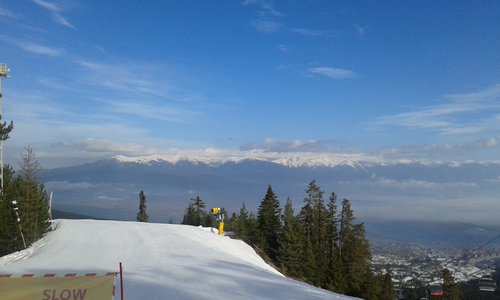

In [41]:
img_first = Image.open("panorama2.png")
img_first

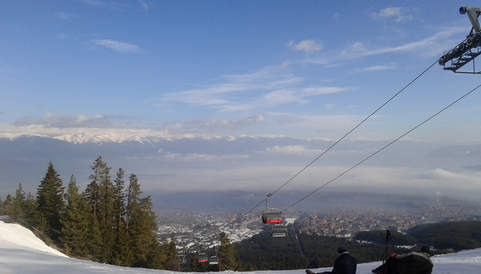

In [42]:
img_second = Image.open("panorama1.png")
img_second

In [43]:
img_first.close()
img_second.close()

In [71]:
# metoda koja posle zadavanja zajedničkih tačaka određuje
# odgovarajuće projektivno preslikavanje i zatim, na osnovu nje
# "lepi" drugu sliku na prvu
def match_pictures(name1, name2, used_algorithm = modified_DLT):
    # selektujemo tačke na slikama
    mutual_points_p1 = makeGUI(msg = "select at least 4 points on the first picture", picture = name1)
    mutual_points_p2 = makeGUI(msg = "select same number of points on the second picture", picture = name2)

    # uzete tačke konvertujemo u homogene koordinate
    mutual_points_p1_ = [from_pixels(e) for e in mutual_points_p1]
    mutual_points_p2_ = [from_pixels(e) for e in mutual_points_p2]
    
    # računamo projektivno preslikavanje između zadatih tačaka,
    # tačnije, njihov inverz.  Ovako ćemo dobiti bolji kvalitet slike, nego ako bismo za
    # piksele sa druge slike računali njihove slike.
    transformation =   \
        np.linalg.inv(used_algorithm(points_pictures = mutual_points_p1_, points_originals = mutual_points_p2_))
    img1 = Image.open(name1)
    img2 = Image.open(name2)
    
    # veličine ulaznih slika
    img1_size = img1.size
    img2_size = img2.size
    
    # konstruišemo novi objekat tipa Image
    img_panorama = Image.new(mode = 'RGB', size = ((img1_size[0] + img2_size[0]), img1.size[1]), color = 'white')
    
    # inicijalno prvi deo slike popunjavamo pikselima sa prve slike
    for i in range(0, img1_size[0]):
        for j in range(0, img1_size[1]):
            img_panorama.putpixel((i,j),img1.getpixel((i,j)))
            
    # prolazimo kroz sve piksele (i,j) sa dela slike gde će se "nalepiti" naša slika
    # i proveravamo čije su oni slike (gledano sa druge slike).
    for i in range(int(img1_size[0] * 0.8), img_panorama.size[0]):
        for j in range(0, img1_size[1]):
            transformation = np.transpose(transformation)
            
            new_point = np.dot([i,j,1], transformation)
            
            if new_point[2] == 0:
                continue
            
            new_point /= new_point[2]
            
            new_point = [math.ceil(e) for e in new_point]
            new_point = new_point[:2]
            
            if new_point[0] < 0 or new_point[1] < 0 or \
              new_point[0] > (img2_size[0] - 1) or new_point[1] > (img2_size[1] - 1):
                continue
            
            col2 = img2.getpixel((new_point[0],new_point[1]))
            
            if i < img1_size[0]:
                col1 = img1.getpixel((i, j))  
                col = ((col1[0] + col2[0]) // 2, (col1[1] + col2[1]) // 2, (col1[2] + col2[2]) // 2)
            
            else:
                col = col2
            
            img_panorama.putpixel((i,j), col)
    return img_panorama
                

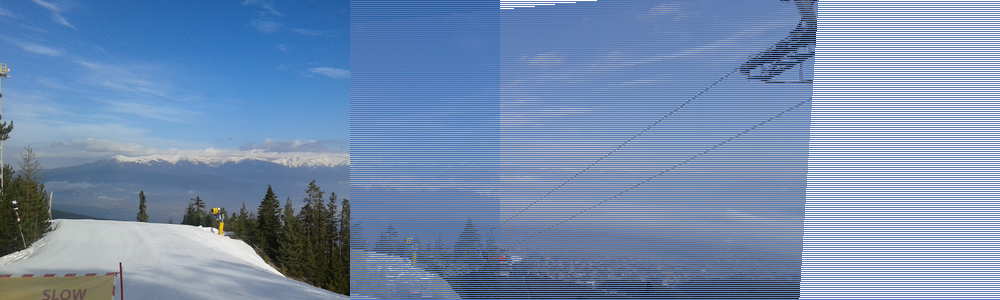

In [83]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png') # 6 mutual points

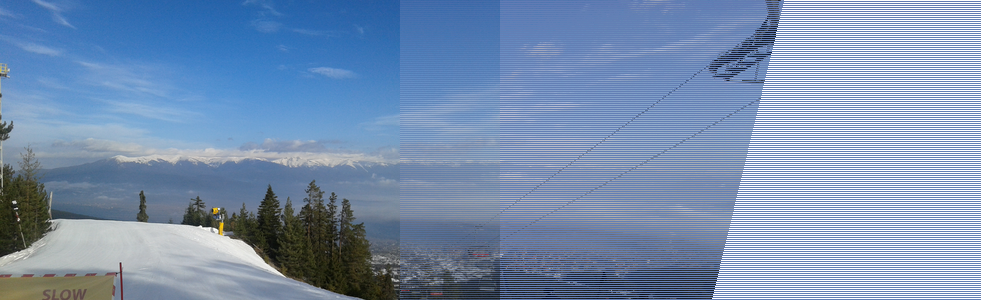

In [62]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png') # 9 mutual points

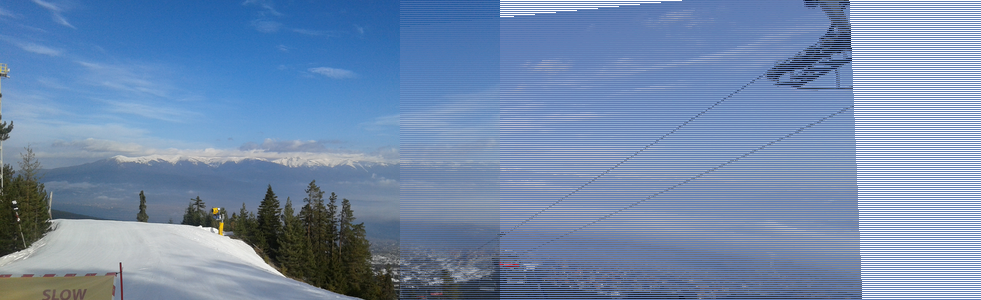

In [63]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png') # 11 mutual points

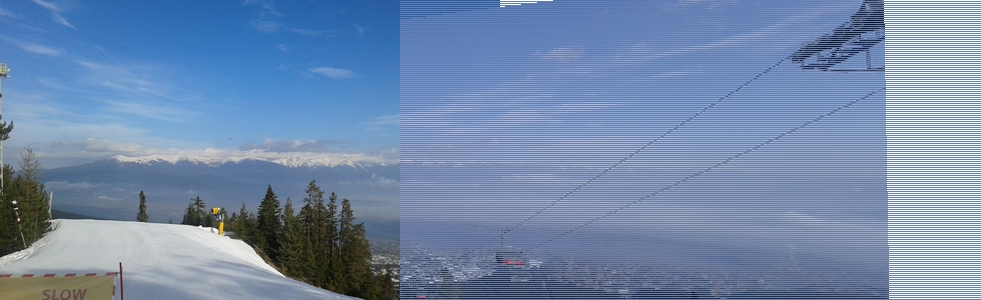

In [69]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png') # 14 mutual points

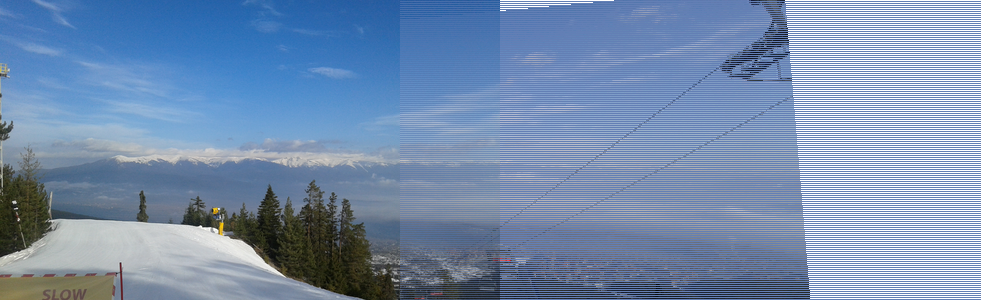

In [72]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png') # 16 points

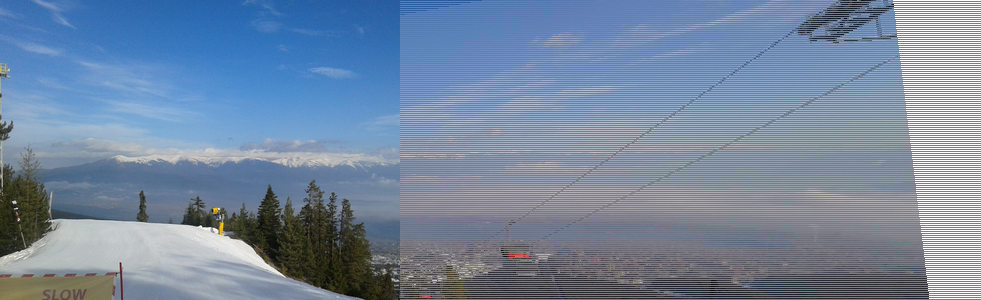

In [70]:
match_pictures(name1 = 'panorama2.png', name2 = 'panorama1.png')